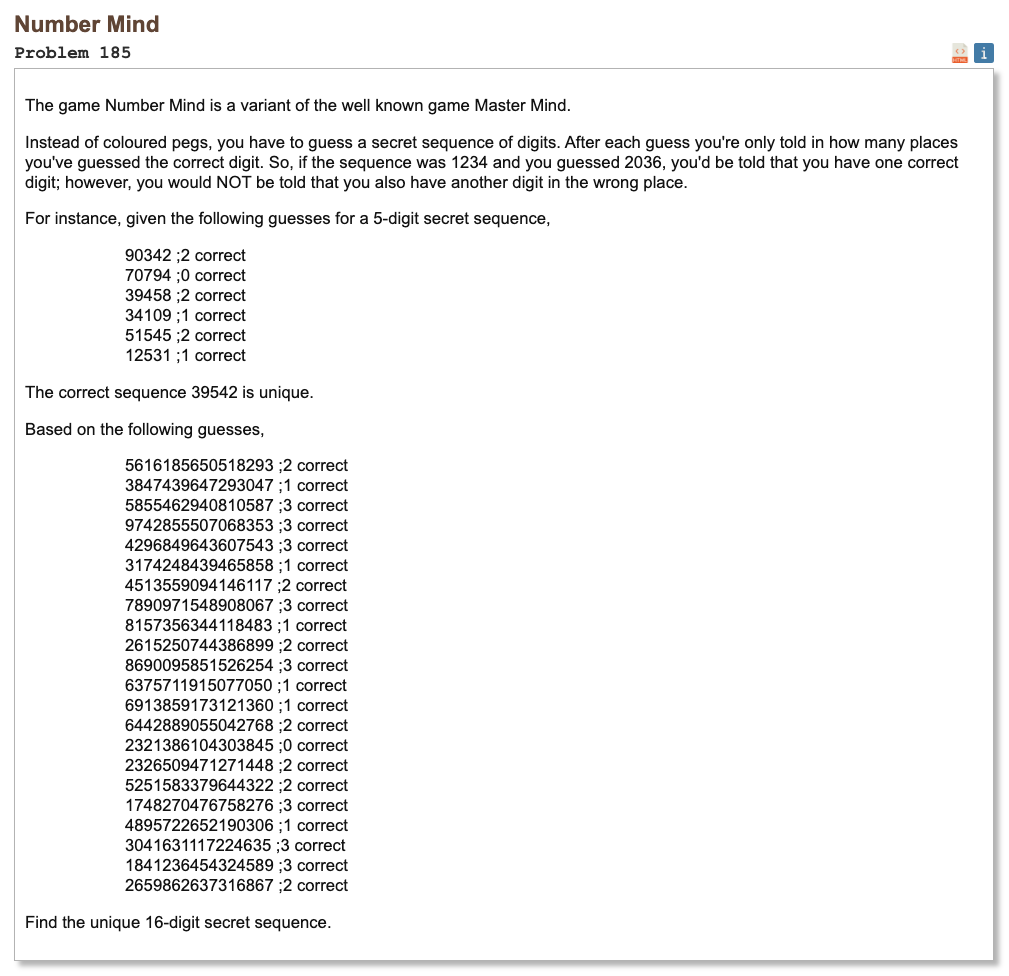

## Initial approach

* turn each clue into a list of digits plus the number of correct positions in that guess
* think of the secret as 16 variables, each position can be any digit from 0 to 9 at the start
* use all guesses in order of increasing “correct count” so the tightest constraints are applied first
* for one guess, find positions where its digit is still allowed, then use itertools.combinations to choose which of those positions are the ones that must be correct
* in a branch, fix the chosen positions to that digit and remove that digit from all other positions of that guess
* if any position loses all possible digits, stop exploring that branch
* recurse over all guesses, so each branch encodes exactly how many positions match in every clue
* after all guesses are processed, every position is forced to a single digit and that 16 digit number is verified against all clues

In [1]:
from itertools import combinations

guesses_str = [
    ("5616185650518293", 2),
    ("3847439647293047", 1),
    ("5855462940810587", 3),
    ("9742855507068353", 3),
    ("4296849643607543", 3),
    ("3174248439465858", 1),
    ("4513559094146117", 2),
    ("7890971548908067", 3),
    ("8157356344118483", 1),
    ("2615250744386899", 2),
    ("8690095851526254", 3),
    ("6375711915077050", 1),
    ("6913859173121360", 1),
    ("6442889055042768", 2),
    ("2321386104303845", 0),
    ("2326509471271448", 2),
    ("5251583379644322", 2),
    ("1748270476758276", 3),
    ("4895722652190306", 1),
    ("3041631117224635", 3),
    ("1841236454324589", 3),
    ("2659862637316867", 2),
]

guesses = [([int(c) for c in s], k) for s, k in guesses_str]
n = len(guesses[0][0])

def apply_guess(domains, guess_digits, correct):
    n_local = len(guess_digits)
    equal_forced = []
    candidate = []
    for i in range(n_local):
        if guess_digits[i] in domains[i]:
            if len(domains[i]) == 1 and next(iter(domains[i])) == guess_digits[i]:
                equal_forced.append(i)
            else:
                candidate.append(i)
    if len(equal_forced) > correct:
        return []
    if len(equal_forced) + len(candidate) < correct:
        return []
    needed = correct - len(equal_forced)
    if needed == 0:
        chosen_sets = [set()]
    else:
        chosen_sets = [set(c) for c in combinations(candidate, needed)]
    results = []
    for chosen in chosen_sets:
        new_domains = [d.copy() for d in domains]
        equal_positions = set(equal_forced) | chosen
        ok = True
        for i in range(n_local):
            if i in equal_positions:
                if guess_digits[i] not in new_domains[i]:
                    ok = False
                    break
                new_domains[i] = {guess_digits[i]}
            else:
                if guess_digits[i] in new_domains[i]:
                    new_domains[i].discard(guess_digits[i])
                    if not new_domains[i]:
                        ok = False
                        break
        if ok:
            results.append(new_domains)
    return results

def check_solution(sol_digits):
    for gd, c in guesses:
        match = sum(1 for i in range(n) if sol_digits[i] == gd[i])
        if match != c:
            return False
    return True

order = list(range(len(guesses)))
order.sort(key=lambda idx: guesses[idx][1])

def solve(idx, domains):
    if idx == len(order):
        sol = [None] * n
        def dfs_pos(pos):
            if pos == n:
                return sol[:] if check_solution(sol) else None
            for d in domains[pos]:
                sol[pos] = d
                r = dfs_pos(pos + 1)
                if r is not None:
                    return r
            sol[pos] = None
            return None
        return dfs_pos(0)
    g_idx = order[idx]
    gd, c = guesses[g_idx]
    for new_domains in apply_guess(domains, gd, c):
        res = solve(idx + 1, new_domains)
        if res is not None:
            return res
    return None

In [2]:
%%time

initial_domains = [set(range(10)) for _ in range(n)]
solution_digits = solve(0, initial_domains)
result = int("".join(str(d) for d in solution_digits))
print("Result:", result)

Result: 4640261571849533
CPU times: user 16.3 s, sys: 46.1 ms, total: 16.3 s
Wall time: 16.4 s
